<a href="https://colab.research.google.com/github/pyoph/projetNLP/blob/main/projetNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from xgboost import XGBClassifier
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.getcwd()

'/content'

In [4]:
#Ouverture des fichiers
tws = pd.read_csv("/content/drive/MyDrive/transcriptions_with_sex (1).csv",sep =",")
fws = pd.read_csv("/content/drive/MyDrive/fws.csv",sep = ";")

In [5]:
fws.head()
tws.head()

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme


In [ ]:
fws.shape[0]

6946

In [ ]:
fws.head()

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951


In [ ]:
tws.head()

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme


In [ ]:
#Calcul du pourcentage de valeurs manquantes pour le fichier tws

total_missing = tws.isna().sum().sum()

total_cells = tws.size

percentage_missing = (total_missing / total_cells) * 100

print(percentage_missing)

7.659151193633952


In [ ]:
#Calcul du pourcentage de valeurs manquantes pour le fichier fws

total_missing = fws.isna().sum().sum()

total_cells = fws.size

percentage_missing = (total_missing / total_cells) * 100

print(percentage_missing)

0.0


In [32]:
#Récupération des features

tws['surname'] = tws['groundtruth'].str.extract(r'surname:\s*([^\s]+)')
tws['firstname'] = tws['groundtruth'].str.extract(r'firstname:\s*([^\s]+)')
tws['occupation'] = tws['groundtruth'].str.extract(r'occupation:\s*([^\s]+)')
tws['link'] = tws['groundtruth'].str.extract(r'link:\s*([^\s]+)')
tws['age'] = tws['groundtruth'].str.extract(r'age:\s*([^\s]+)')
tws['employer'] = tws['groundtruth'].str.extract(r'employer:\s*([^\s]+)')
tws['nom'] = tws['prediction'].str.extract(r'nom:\s*([^\s]+)')
tws['prénom'] = tws['prediction'].str.extract(r'prénom:\s*([^\s]+)')
tws['date_naissance'] = tws['prediction'].str.extract(r'date_naissance:\s*([^\s]+)')
tws['relation'] = tws['prediction'].str.extract(r'relation:\s*([^\s]+)')


In [12]:
#Lemmatization


# Télécharger les ressources nécessaires pour nltk (une seule fois)
nltk.download('wordnet')

# Initialiser le lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatizer les données de chaque colonne
columns_to_lemmatize = ['firstname', 'prénom', 'occupation', 'relation']

for col in columns_to_lemmatize:
    # Lemmatizer chaque mot dans la colonne
    tws[col] = tws[col].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in str(x).split() if wordnet.synsets(word)]) if isinstance(x, str) else x)

# Afficher les premières lignes du DataFrame après le lemmatization
print(tws.head())

                           subject_line  \
0  ebb26ada-044c-4c62-9dbc-a9c8d505d31c   
1  338496f5-e4ca-43ac-aa5c-429cb3f6ac00   
2  e6a279da-9b6f-4f49-b498-64857bc50d1e   
3  7534deca-39e8-4f00-be17-c12460015de1   
4  ef334a66-a504-418a-9872-e7c9db923488   

                                         groundtruth  \
0  surname: Chardon firstname: Marie occupation: ...   
1  surname: Lhopital firstname: Louis-Jean occupa...   
2  surname: Papin firstname: Marie occupation: id...   
3  surname: Lavocat firstname: Marie link: femme ...   
4      surname: Benne firstname: Marguerite age: 78    

                                          prediction    sex   surname  \
0  nom: Chardon prénom: Marie date_naissance: 30 ...  femme   Chardon   
1  nom: Lhopital prénom: Louis Jean date_naissanc...  homme  Lhopital   
2  nom: Pyrin prénom: Marie date_naissance: 55 re...  femme     Papin   
3  nom: Lavocat prénom: Marie date_naissance: 187...  femme   Lavocat   
4  nom: Benne prénom: Marguerite date_n

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


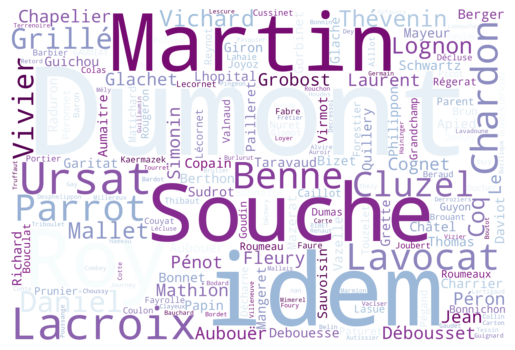

In [ ]:
listeNoms = []

for i in range(0,len(list(tws['surname']))) :
  listeNoms.append(str(tws['surname'][i]))

texte = " ".join(listeNoms)

word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="white",
        colormap="BuPu",
        collocations=False,
        stopwords=set(),
        ).generate(texte)

# Afficher le nuage de mots
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

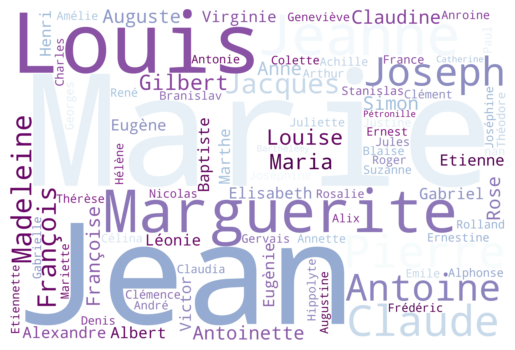

In [ ]:
#Wordcloud pour la liste des prénoms

#Enregistrement des prénoms dans une liste pour les afficher dans un Wordcloud
listePrenoms = []

for i in range(0,len(list(tws['firstname']))) :
  listePrenoms.append(str(tws['firstname'][i]))

texte = " ".join(listePrenoms)

word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="white",
        colormap="BuPu",
        collocations=False,
        stopwords=set(),
        ).generate(texte)

# Afficher le nuage de mots
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

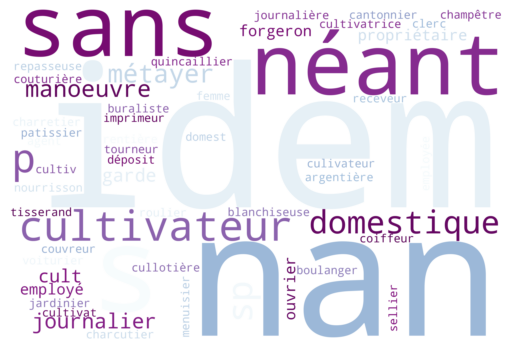

In [ ]:
#Enregistrement des occupations dans une liste pour les afficher dans un Wordcloud
listeOccupations = []

for i in range(0,len(list(tws['occupation']))) :
  listeOccupations.append(str(tws['occupation'][i]))

texte = " ".join(listeOccupations)

word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="white",
        colormap="BuPu",
        collocations=False,
        stopwords=set(),
        ).generate(texte)

# Afficher le nuage de mots
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Isolement des lignes avec sexe amigu
tws_ambigu = tws[tws['sex'] == 'ambigu']

tws = tws[~tws['sex'].str.contains('ambigu', case=False, na=False)]


In [ ]:
tws_ambigu.head()

,subject_line,groundtruth,prediction,sex,surname,firstname,occupation,link,age,employer,nom,prénom,date_naissance
17,421b3e1f-ff91-4871-a8de-3af62c58e3bc,surname: Daniel firstname: Claude occupation: ...,nom: Demil prénom: Claude date_naissance: 33 l...,ambigu,Daniel,Claude,journalier,chef,33,NaN,Demil,Claude,33
59,8339da37-3493-4684-a9fd-090411f33d01,surname: Gorbinet firstname: Jeanne occupation...,nom: Gorbinet prénom: Jeanne date_naissance: 6...,ambigu,Gorbinet,Jeanne,idem,chef,66,NaN,Gorbinet,Jeanne,66
94,e1e6fb82-6417-4dcf-8eaa-7d5a5e9f6551,surname: Roumeau firstname: Claude occupation:...,nom: Roumeau prénom: Vaude date_naissance: 180...,ambigu,Roumeau,Claude,cultivateur,chef,30,NaN,Roumeau,Vaude,1804
123,e6927138-689e-4d70-89c2-cf86f7171fd1,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 84 ...,ambigu,Chardon,Marie,idem,chef,84,NaN,Chardon,Marie,84
124,5b244d56-e1da-4b57-934a-0a1234f34709,surname: Grillé firstname: Emile occupation: i...,nom: d prénom: Emile date_naissance: 2 lieux_n...,ambigu,Grillé,Emile,idem,idem,2,idem,d,Emile,2


In [36]:
#Première approche on cherche que est le genre à partir du prénom en fonction du nombre d'hommes ou de femmes qui le portent

# Définir une fonction pour déterminer le genre majoritaire d'un prénom
def determine_genre(prenom):
    # Recherche du prénom dans le DataFrame fws
       if not str(prenom).strip() == '':
        # Recherche du prénom dans le DataFrame fws
        prenom_lower = prenom.lower()  # Convertir le prénom en minuscules pour la recherche insensible à la casse
        match = fws[fws['firstname'].str.lower().str.contains(prenom_lower, na=False)]

        if not match.empty:
            # Si le prénom est trouvé dans fws, déterminer le genre majoritaire
            hommes = match['male'].sum()
            femmes = match['female'].sum()
            if hommes > femmes:
                return 'homme'
            elif hommes < femmes:
                return 'femme'
            else:
                return 'Indéterminé'  # En cas d'égalité
        else:
            # Si le prénom n'est pas trouvé dans fws, retourner 'Inconnu'
            return 'Inconnu'

        # Si le prénom est une chaîne vide, retourner 'Inconnu'

tws['genreGt'] = ''
tws['genrePred'] = ''


for i in range(0,len(list(tws['firstname']))) :
  tws['genreGt'][i] = determine_genre(str(tws['firstname'][i]))
  tws['genrePred'][i] = determine_genre(str(tws['prénom'][i]))


tws.head()

,subject_line,groundtruth,prediction,sex,surname,firstname,occupation,link,age,employer,nom,prénom,date_naissance,relation,genreGt,genrePred
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme,Chardon,Marie,idem,fille,30,NaN,Chardon,Marie,30,NaN,femme,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme,Lhopital,Louis-Jean,sp,chef,67,NaN,Lhopital,Louis,67,NaN,Inconnu,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme,Papin,Marie,idem,idem,15,idem,Pyrin,Marie,55,d,femme,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme,Lavocat,Marie,NaN,femme,NaN,NaN,Lavocat,Marie,1875,NaN,femme,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme,Benne,Marguerite,NaN,NaN,78,NaN,Benne,Marguerite,78,'',femme,femme


In [37]:
#Calcul des accuracy
# Calculer l'accuracy pour la colonne 'genreGt'
accuracy_genreGt = (tws['genreGt'] == tws['sex']).mean() * 100
print("Accuracy de genreGt : {:.2f}%".format(accuracy_genreGt))

# Calculer l'accuracy pour la colonne 'genrePred'
accuracy_genrePred = (tws['genrePred'] == tws['sex']).mean() * 100
print("Accuracy de genrePred : {:.2f}%".format(accuracy_genrePred))


Accuracy de genreGt : 92.53%
Accuracy de genrePred : 82.99%


In [26]:
fws.head()

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951


([<matplotlib.axis.XTick at 0x7ac4bd1155d0>,
 [Text(0, 0, 'femme'), Text(1, 0, 'homme')])

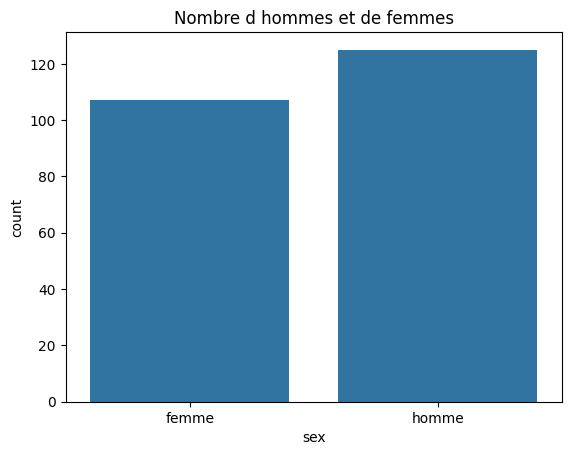

In [ ]:
#Statistiques descriptives

#Sexe

sns.countplot(x='sex',data = tws)

plt.title('Nombre d hommes et de femmes')

plt.xticks([0,1],('femme','homme'))

In [ ]:
#Statistiques sur les premières lettres des prénoms

alphabets= ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P',

            'Q','R','S','T','U','V','W','X','Y','Z']

startletter_count = {}

for letter in alphabets:
    # Filtrer les lignes où le prénom commence par la lettre et où le prénom n'est pas manquant
    filtered_rows = tws[tws['firstname'].str.startswith(letter) & tws['firstname'].notna()]
    startletter_count[letter] = filtered_rows.shape[0]



print(startletter_count)

{'A': 29, 'B': 4, 'C': 13, 'D': 1, 'E': 11, 'F': 11, 'G': 10, 'H': 4, 'I': 0, 'J': 52, 'K': 0, 'L': 15, 'M': 51, 'N': 1, 'O': 0, 'P': 11, 'Q': 0, 'R': 7, 'S': 5, 'T': 2, 'U': 0, 'V': 4, 'W': 0, 'X': 0, 'Y': 0, 'Z': 0}


In [46]:
#Préparation des données

#Encodage de la variable sex avec 0 ou 1
Y = list(tws['sex'])
encoder= LabelEncoder()

Y = encoder.fit_transform(Y)


In [49]:
def vectoriserChamp(champ) :
  tws[champ].fillna('', inplace=True)
  return TfidfVectorizer(analyzer='char', ngram_range=(2, 3)).fit_transform(tws[champ])



In [50]:
#Création des objets TfId
tfidf_features_firstname =vectoriserChamp('firstname')
tfidf_features_occupation = vectoriserChamp('occupation')
tfidf_features_link = vectoriserChamp('link')

In [42]:
#Création de la matrice de variables explicatives
def creerVecteurVariablesExplicatives() :
  X = np.concatenate((tfidf_features_firstname.toarray(), tfidf_features_occupation.toarray()), axis=1)
  X = np.concatenate((X,tfidf_features_link.toarray()),axis = 1)
  return X


In [43]:
#Modèles
#Régression logisitique
def regressionLogistique() :
  X = creerVecteurVariablesExplicatives()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
  logistic_regression_model = LogisticRegression()
  logistic_regression_model.fit(X_train, y_train)

  predictions = logistic_regression_model.predict(X_test)

  accuracy = logistic_regression_model.score(X_test, y_test)
  print("Accuracy:", accuracy)
  return logistic_regression_model


In [44]:
#Naive Bayes
def naiveBayes() :
  X = creerVecteurVariablesExplicatives()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
  NB_model= MultinomialNB()
  NB_model.fit(X_train,y_train)
  NB_y_pred = NB_model.predict(X_test)
  accuracy = NB_model.score(X_test, y_test)
  print("Accuracy:", accuracy)
  return NB_model


In [38]:
#Modèle XGLBoost
def XGLBoost() :
  X = creerVecteurVariablesExplicatives()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
  XGB_model = XGBClassifier(use_label_encoder= False)
  XGB_model.fit(X_train,y_train)
  XGB_y_pred = XGB_model.predict(X_test)
  accuracy = XGB_model.score(X_test, y_test)
  print("Accuracy:", accuracy)
  return XGB_model

In [40]:
#Modèle Adaboost
def adaboost() :
  X = creerVecteurVariablesExplicatives()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
  adaboost_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
  adaboost_clf.fit(X_train, y_train)
  y_pred = adaboost_clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy du modèle Adaboost : {:.2f}%".format(accuracy * 100))
  accuracy = adaboost_clf.score(X_test, y_test)
  print("Accuracy:", accuracy)
  return adaboost_clf

In [ ]:
modeleLogistique = regressionLogistique()

Accuracy: 0.9148936170212766


In [ ]:
NBModel = naiveBayes()

Accuracy: 0.9148936170212766


In [ ]:
modeleXGL = XGLBoost()

Accuracy: 0.9361702127659575


In [53]:
modeleAdaboost = adaboost()

Accuracy du modèle Adaboost : 83.67%
Accuracy: 0.8367346938775511


In [ ]:
def predictionNouvelleEntree (prenom,occupation,link,modele) :
  tws['firstname'].fillna('', inplace=True)
  tws['occupation'].fillna('', inplace=True)
  tws['link'].fillna('', inplace=True)
  tfidf_new_firstname = TfidfVectorizer(analyzer='char', ngram_range=(2, 3)).fit(tws['firstname'])
  tfidf_new_occupation = TfidfVectorizer(analyzer='char', ngram_range=(2, 3)).fit(tws['occupation'])
  tfidf_new_link = TfidfVectorizer(analyzer='char', ngram_range=(2, 3)).fit(tws['link'])
  X_new_firstname = tfidf_new_firstname.transform([prenom])
  X_new_occupation = tfidf_new_occupation.transform([occupation])
  X_new_link = tfidf_new_link.transform([link])
  X_new = np.concatenate((X_new_firstname.toarray(), X_new_occupation.toarray(), X_new_link.toarray()), axis=1)
  prediction = modele.predict(X_new)
  return prediction




In [ ]:
tws.head()

,subject_line,groundtruth,prediction,sex,surname,firstname,occupation,link,age,employer,nom,prénom,date_naissance
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme,Chardon,Marie,idem,fille,30,NaN,Chardon,Marie,30
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme,Lhopital,Louis-Jean,sp,chef,67,NaN,Lhopital,Louis,67
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme,Papin,Marie,idem,idem,15,idem,Pyrin,Marie,55
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme,Lavocat,Marie,,femme,NaN,NaN,Lavocat,Marie,1875
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme,Benne,Marguerite,,,78,NaN,Benne,Marguerite,78


In [ ]:
#Test prédiction nouvelle entrée modèle Naive Bayes
predictionNB = predictionNouvelleEntree('Marie','menuisier','chef',NBModel)
print(predictionNB)

[0]


In [ ]:
#Test sur une entrée
prediction = predictionNouvelleEntree('Marie','menuisier','chef',modeleLogistique)
print(prediction)


[0]


In [ ]:
#Prédictions pour les entrées ambigu
predictions_ambigu = []

for index, row in tws_ambigu.iterrows():

    prediction = predictionNouvelleEntree(row['firstname'], row['occupation'], row['link'],NBModel)

    if prediction[0] == 0:
        tws_ambigu.at[index, 'sex_ambigu'] = 'homme'
    elif prediction[0] == 1:
        tws_ambigu.at[index, 'sex_ambigu'] = 'femme'

    predictions_ambigu.append(prediction[0])



In [ ]:
tws_ambigu.head()

,subject_line,groundtruth,prediction,sex,surname,firstname,occupation,link,age,employer,nom,prénom,date_naissance,sex_ambigu
17,421b3e1f-ff91-4871-a8de-3af62c58e3bc,surname: Daniel firstname: Claude occupation: ...,nom: Demil prénom: Claude date_naissance: 33 l...,ambigu,Daniel,Claude,journalier,chef,33,NaN,Demil,Claude,33,femme
59,8339da37-3493-4684-a9fd-090411f33d01,surname: Gorbinet firstname: Jeanne occupation...,nom: Gorbinet prénom: Jeanne date_naissance: 6...,ambigu,Gorbinet,Jeanne,idem,chef,66,NaN,Gorbinet,Jeanne,66,femme
94,e1e6fb82-6417-4dcf-8eaa-7d5a5e9f6551,surname: Roumeau firstname: Claude occupation:...,nom: Roumeau prénom: Vaude date_naissance: 180...,ambigu,Roumeau,Claude,cultivateur,chef,30,NaN,Roumeau,Vaude,1804,femme
123,e6927138-689e-4d70-89c2-cf86f7171fd1,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 84 ...,ambigu,Chardon,Marie,idem,chef,84,NaN,Chardon,Marie,84,homme
124,5b244d56-e1da-4b57-934a-0a1234f34709,surname: Grillé firstname: Emile occupation: i...,nom: d prénom: Emile date_naissance: 2 lieux_n...,ambigu,Grillé,Emile,idem,idem,2,idem,d,Emile,2,femme


In [ ]:
#Réseau de neurones
X = creerVecteurVariablesExplicatives()

#Division en échantillon d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Construction du modèle RNN
inputs = Input(shape=(1, X_train.shape[1]))  # la forme devient (batch_size, timesteps, input_dim)
x = LSTM(units=64)(inputs)  # Couche LSTM
outputs = Dense(units=1, activation='sigmoid')(x)  # Couche de sortie

# Création du modèle
model = Model(inputs=inputs, outputs=outputs)

# Compilation du modèle et entraînement...

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Ajouter une nouvelle dimension pour représenter les pas de temps
X_train_reshaped = np.expand_dims(X_train, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

# Entraînement du modèle
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32)

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/10
6/6 [==============================] - 2s 5ms/step - loss: 0.6843 - accuracy: 0.7297
Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6577 - accuracy: 0.9081
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.9351
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6014 - accuracy: 0.9405
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.5695 - accuracy: 0.9405
Epoch 6/10
6/6 [==============================] - 0s 5ms/step - loss: 0.5355 - accuracy: 0.9514
Epoch 7/10
6/6 [==============================] - 0s 6ms/step - loss: 0.4986 - accuracy: 0.9514
Epoch 8/10
6/6 [==============================] - 0s 5ms/step - loss: 0.4629 - accuracy: 0.9568
Epoch 9/10
6/6 [==============================] - 0s 5ms/step - loss: 0.4235 - accuracy: 0.9622
Epoch 10/10
2/2 [==============================] - 0s 8ms/step - loss: 0.3938 - accuracy: 0.9149
Loss: 0.3938457667827606
Accuracy: 0.91

In [ ]:
#Prédiction de nouvelle entrée pour un réseau de neurones
def predictionNouvelleEntreeNN(prenom, occupation, link, modele):
    # Prétraitement des nouvelles données
    tws['firstname'].fillna('', inplace=True)
    tws['occupation'].fillna('', inplace=True)
    tws['link'].fillna('', inplace=True)
    tfidf_new_firstname = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=1000).fit(tws['firstname'])
    tfidf_new_occupation = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=1000).fit(tws['occupation'])
    tfidf_new_link = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=1000).fit(tws['link'])

    X_new_firstname = tfidf_new_firstname.transform([prenom])
    X_new_occupation = tfidf_new_occupation.transform([occupation])
    X_new_link = tfidf_new_link.transform([link])

    # Convertir les données en séquences de caractéristiques
    X_new_firstname = X_new_firstname.toarray()
    X_new_occupation = X_new_occupation.toarray()
    X_new_link = X_new_link.toarray()

    # Concaténer les données prétraitées
    X_new = np.concatenate((X_new_firstname, X_new_occupation, X_new_link), axis=1)
    X_new_reshaped = np.expand_dims(X_new, axis=1)


    # Faire une prédiction sur les nouvelles données
    prediction = modele.predict(X_new_reshaped)

    return prediction


In [ ]:
prediction = predictionNouvelleEntreeNN('Marie','menuisier','chef',model)

if prediction >= 0.5 :
  print("homme")
else :
  print("femme")

1/1 [==============================] - 0s 272ms/step
homme


In [ ]:
#Prédictions pour les entrées ambigu avec le réseau de neurones
predictions_ambigu = []

for index, row in tws_ambigu.iterrows():

    prediction = predictionNouvelleEntreeNN(row['firstname'], row['occupation'], row['link'],model)

    if prediction[0] == 0:
        tws_ambigu.at[index, 'sex_ambigu'] = 'homme'
    elif prediction[0] == 1:
        tws_ambigu.at[index, 'sex_ambigu'] = 'femme'

    predictions_ambigu.append(prediction[0])

1/1 [==============================] - 0s 23ms/step


In [ ]:
tws_ambigu.head()

,subject_line,groundtruth,prediction,sex,surname,firstname,occupation,link,age,employer,nom,prénom,date_naissance,sex_ambigu
17,421b3e1f-ff91-4871-a8de-3af62c58e3bc,surname: Daniel firstname: Claude occupation: ...,nom: Demil prénom: Claude date_naissance: 33 l...,ambigu,Daniel,Claude,journalier,chef,33,NaN,Demil,Claude,33,femme
59,8339da37-3493-4684-a9fd-090411f33d01,surname: Gorbinet firstname: Jeanne occupation...,nom: Gorbinet prénom: Jeanne date_naissance: 6...,ambigu,Gorbinet,Jeanne,idem,chef,66,NaN,Gorbinet,Jeanne,66,femme
94,e1e6fb82-6417-4dcf-8eaa-7d5a5e9f6551,surname: Roumeau firstname: Claude occupation:...,nom: Roumeau prénom: Vaude date_naissance: 180...,ambigu,Roumeau,Claude,cultivateur,chef,30,NaN,Roumeau,Vaude,1804,femme
123,e6927138-689e-4d70-89c2-cf86f7171fd1,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 84 ...,ambigu,Chardon,Marie,idem,chef,84,NaN,Chardon,Marie,84,homme
124,5b244d56-e1da-4b57-934a-0a1234f34709,surname: Grillé firstname: Emile occupation: i...,nom: d prénom: Emile date_naissance: 2 lieux_n...,ambigu,Grillé,Emile,idem,idem,2,idem,d,Emile,2,femme
